### Alikhan Bulatov 



#Regression

Goal is to different models on a given data set, and find the one that performs best

## Getting the data for the assignment

In [0]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [0]:
fetch_housing_data()

In [0]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [0]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [0]:
housing.loc[0,:]

longitude              -122.23
latitude                 37.88
housing_median_age          41
total_rooms                880
total_bedrooms             129
population                 322
households                 126
median_income           8.3252
median_house_value      452600
ocean_proximity       NEAR BAY
Name: 0, dtype: object

## Preprocessing

### Fix the categories in the categorical variable

In [0]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add two more features (feature engineering example)
Sometimes it is wise to add additional useful features. This is just an example. A **domain expert** in this area (e.g. an expert real estate consultant), suggested we add these two columns. For a dataset we get, we always can think about additional features we can add to help to get a better model.

In [0]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [0]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [0]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

In [0]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,population_per_household,INLAND,ISLAND,LESS_1H_OCEAN,NEAR_BAY,NEAR_OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,2.555556,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,2.109842,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,2.802260,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,2.547945,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,2.181467,0,0,0,1,0


### Check the data

In [0]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


# Regression

### 1. Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.

Use random state of 123


In [0]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=123)

### Features

In [0]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [0]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### 2. Polynomial transformations

### Use PolynomialFeatures from sklearn.preprocessing

The idea of linear regression is based on linear combination of features. What if the best regression model is not linear? For example if it look like a curve? You know that curve functions are not linear. For example if we have one feautre, what if $y = x^2$ is actual curve the regressor model should predict? Linear Regression is not capable of creating a curve like that. But `PolynomialFeatures` trick will solve this issue for us. It adds additional column to our feature matrix, which are some powers of the current feature. Please take a look at documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).

In [0]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly.fit(X_tr)
X_tr = poly.fit_transform(X_tr)
X_te = poly.fit_transform(X_te)

##### You should obtain X_tr and X_te with 136 columns each, since originally you had 15 features.

##### With m original features, the new added polynomial features of degree 2 are: $(m^2-m)/2+m+1$. Why?

##### These, plus the original features gives a total of  $(m^2-m)/2+2m+1$

In [0]:
print("Original number of features: "+str(len(features)))
print("Final number of features: "+str(X_tr.shape[1]))

Original number of features: 15
Final number of features: 136


### 3. Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.fit_transform(X_te)

#### Comparing models

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### 4. Linear regression on original features (no transformations) --- benchmark

#### Your goal is to find the model that minimizes the RMSE score. Read more [here](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) and [here](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error) (It is similar to Accuracy metric for Classification)

In [0]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [68447.82279847 69777.52395334 68778.95097477 68915.51212139]
Mean: 68979.95246199444


### 5. Linear regression  (on transformed features: polynomial transformation + scaling)

Now do as in 4 but with the original and transformed features (136 features)

In [0]:
lin_scores = cross_val_score(LinearRegression(), X_tr, y_tr, scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [3.42297965e+13 6.25723991e+04 6.17260337e+04 2.07983224e+16]
Mean: 5208138048277104.0


If the error on the cross-validation is too high it is because the model is over-fitting. Regularization is needed.

### 6. Ridge regression (A regularized version of Linear Regression)

In [0]:
from sklearn.linear_model import Ridge
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
grid_search_rr = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_rr.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [0]:
print(grid_search_rr.best_params_)
print(np.sqrt(-grid_search_rr.best_score_))

{'alpha': 1000}
67718.30356942998


### 7. Lasso regression (A regularized version of Linear Regression)

Now do the same as in 6 but with Lasso

In [0]:
from sklearn.linear_model import Lasso
param_grid_lr = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
grid_search_lr = GridSearchCV(Lasso(tol=1), param_grid_lr, cv=3, scoring='neg_mean_squared_error')
grid_search_lr.fit(X_tr, y_tr)
print(grid_search_lr.best_params_)
print(np.sqrt(-grid_search_lr.best_score_))

{'alpha': 1000}
68668.7924536196


### 8. Elastic Net Regression (Combination of Lasso and Ridge)

Do the same as in 6 and 7, but now with Elastic Net (Another modified version of Linear Regression). However, the grid search should be over the parameters alpha and  l 1ratio. Use just 3 values for l1_ratio.

In [0]:
from sklearn.linear_model import ElasticNet
param_grid_enr = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000],'l1_ratio': [0,0.5,1]}]
grid_search_enr = GridSearchCV(ElasticNet(tol=1), param_grid_enr, cv=3, scoring='neg_mean_squared_error')
grid_search_enr.fit(X_tr, y_tr)
print(grid_search_enr.best_params_)
print(np.sqrt(-grid_search_enr.best_score_))

{'alpha': 1000, 'l1_ratio': 1}
68668.7924536196


### Evaluating your best model on TESTING data

Choose among grid_search_rr, grid_search_lr, and grid_search_enr, the model with best performance

In [0]:
# Ridge regression is the best model
from sklearn.metrics import mean_squared_error

final_model = grid_search_rr.best_estimator_   ## grid_search SHOULD BE THE BEST GRID SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

65528.76651700726


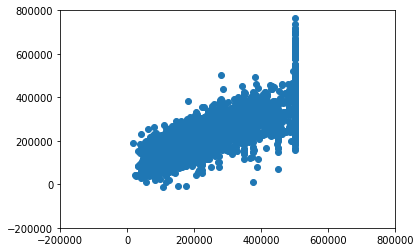

In [0]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

* Predict the price for a new data point

In [0]:
# import data point
data_point_features = [-124.23,36.88,51,950,211,453,189,8.5241,950/189,453/189,0,0,0,1,0]
X_dp = pd.DataFrame([data_point_features],columns=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income',
                                              'rooms_per_household','population_per_household','INLAND','ISLAND','LESS_1H_OCEAN','NEAR_BAY','NEAR_OCEAN'])
# add polynomial features
poly = PolynomialFeatures(2)
poly.fit(X_dp)
X_dp = poly.fit_transform(X_dp)
# scale the data
scaler = StandardScaler()
scaler.fit(X_dp)
X_dp = scaler.fit_transform(X_dp)
# predict the price
prediction = final_model.predict(X_dp)
print('predicted value of a new data points is ',prediction)

predicted value of a new data points is  [[207517.62022426]]


## Predict a new 'median_house_value'

Assume you created the best model and deploy it on production server. A new house comes to market with the following features. What is your prediction for its `median_house_value` ?
(Do not forget you need to apply preprocessing steps such as scaling)


```
longitude              -124.23
latitude                 36.88
housing_median_age          51
total_rooms                950
total_bedrooms             211
population                 453
households                 189
median_income           8.5241
median_house_value      452600
ocean_proximity       NEAR BAY
```

### Question: Before you computed the final_rmse on the test data, what was your expected value for this quantity? Does your best model have high variance?

In [0]:
from sklearn.metrics import explained_variance_score

print(explained_variance_score(y_te_estimation, y_te))

0.5135382918307603


I expected the final_rmse to be lower that the previous rmse calculated before. 
It was 68979.95246199444 before and became 65528.76651700726 which is a resonable improvement.

The model has a variance of 0.51 which is a moderate variance
